In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

## Example: Benford's Law

In [18]:
digits = np.arange(1, 10)
benford_model = np.log10(1 + 1/digits)
benford_model

array([0.30103   , 0.17609126, 0.12493874, 0.09691001, 0.07918125,
       0.06694679, 0.05799195, 0.05115252, 0.04575749])

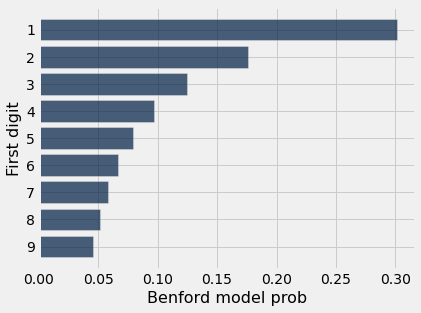

In [3]:
benford = Table().with_columns(
    'First digit', digits,
    'Benford model prob', benford_model)
benford.barh('First digit')

In [4]:
# You don't have to understand how this function works, since it uses Python features from beyond Data 8.
def first_digit(num):
    return int(str(num)[0])

In [5]:
first_digit(32)

3

In [6]:
first_digit(17719087)

1

In [7]:
# County populations from the census data
counties = Table.read_table('data/counties.csv')
counties = counties.where('SUMLEV', 50).select(5,6,9).relabeled(0,'State').relabeled(1,'County').relabeled(2,'Population')
counties.show(3)

State,County,Population
Alabama,Autauga County,54684
Alabama,Baldwin County,183216
Alabama,Barbour County,27336


In [8]:
first_digits = counties.apply(first_digit, 'Population')
counties = counties.with_column('First digit', first_digits)
counties.show(3)

State,County,Population,First digit
Alabama,Autauga County,54684,5
Alabama,Baldwin County,183216,1
Alabama,Barbour County,27336,2


In [9]:
num_counties = counties.num_rows

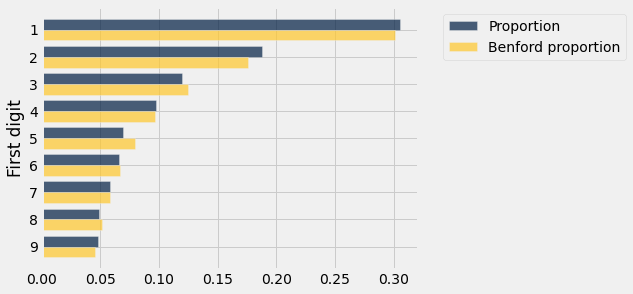

In [10]:
by_digit = counties.group('First digit')
proportions = by_digit.column('count')/num_counties
by_digit = by_digit.with_columns(
    'Proportion', proportions,
    'Benford proportion', benford_model
)
by_digit.drop('count').barh('First digit')

Null hypothesis: Similarities in our Counties proportion and Benford's model are not due to chance

Alternative hypothesis: Similarities in our Counties' propoportion and Benford's model are  due to chance.

Test statistic: TVD

Fill in the blank with "Bigger" or "Smaller":

Smaller values of the test statistic favor the alternative

In [11]:
observed_tvd = sum(abs(proportions - benford_model))/2
observed_tvd

0.01922756971800583

In [12]:
sample_proportions(num_counties, benford_model)

array([0.30521961, 0.17504774, 0.12826225, 0.09866327, 0.0821133 ,
       0.05728835, 0.05824316, 0.04678549, 0.04837683])

In [13]:
simulated_frequencies = sample_proportions(num_counties, benford_model)
tvd = sum(abs(simulated_frequencies - benford_model))/2
tvd

0.023530804890328577

In [14]:
def simulate_county_first_digits():
    simulated_frequencies = sample_proportions(num_counties, benford_model)
    tvd = sum(abs(simulated_frequencies - benford_model))/2
    return tvd

In [15]:
simulated_tvds = make_array()

for i in np.arange(10000):
    simulated_tvds = np.append(simulated_tvds, simulate_county_first_digits())

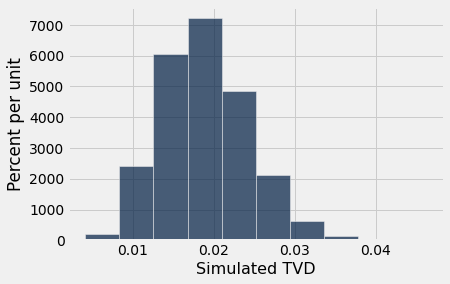

In [16]:
Table().with_column('Simulated TVD', simulated_tvds).hist(0)

In [17]:
np.count_nonzero(simulated_tvds >= observed_tvd) / 10000

0.4455

Are the data consistent with the null hypothesis?

## Example: sleep survey

In [19]:
survey = Table.read_table('data/sleep_survey.csv')
survey

Year,Extraversion,Number of textees,Hours of sleep,Handedness,Sleep position
Second,6,10,7,Right-handed,On your back
Fourth or above,9,25,7,Right-handed,On your left side
First,7,5,8,Right-handed,On your stomach
Second,5,6,8,Right-handed,On your right side
Second,5,10,7,Right-handed,On your right side
Third,8,3,8,Right-handed,On your stomach
Third,8,2,5,Right-handed,On your left side
Second,7,5,6,Right-handed,On your right side
First,8,6,7,Right-handed,On your right side
First,4,5,7,Left-handed,On your right side


In [20]:
def simplify(sleep_position):
    if sleep_position == 'On your left side' or sleep_position == 'On your right side':
        return 'side'
    else:
        return 'back or stomach'
    
survey = survey.with_column(
    'position',
    survey.apply(simplify, 'Sleep position')
).select('position', 'Hours of sleep')

survey

position,Hours of sleep
back or stomach,7
side,7
back or stomach,8
side,8
side,7
back or stomach,8
side,5
side,6
side,7
side,7


In [21]:
survey.group('position', np.average)

position,Hours of sleep average
back or stomach,7.12792
side,7.0328


Null hypothesis: Any differences between average hours of sleep between back/stomach sleepers or side sleepers is due to chance.


Alternative hypothesis: One of the groups get more sleep on average

Test statistic: Absolute value of (Average hours of sleep for side - Average hours of sleep for back/stomach)

Fill in the blank with "Bigger" or "Smaller":

Larger values of the test statistic favor the alternative

In [30]:
def compute_test_statistic(tbl):
    grouped = tbl.group('position', np.average)
    avgs = grouped.column('Hours of sleep average')
    #print(avgs)
    return abs(avgs.item(1) - avgs.item(0))

In [31]:
obs_test_stat = compute_test_statistic(survey)
obs_test_stat

0.09512125823477291

In [32]:
random_labels = survey.sample(with_replacement=False).column('position')

In [33]:
def simulate_under_null():
    random_labels = survey.sample(with_replacement=False).column('position')
    relabeled_tbl = survey.with_column('position', random_labels)
    return compute_test_statistic(relabeled_tbl)


In [34]:
simulated_diffs = make_array()
for i in np.arange(1000):
    null_stat = simulate_under_null()
    simulated_diffs = np.append(simulated_diffs, null_stat)

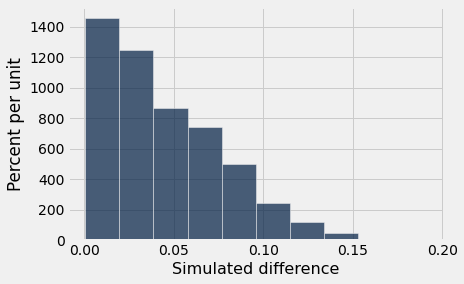

In [35]:
Table().with_column('Simulated difference', simulated_diffs).hist(0)

In [36]:
obs_test_stat

0.09512125823477291

In [38]:
np.mean(simulated_diffs <= obs_test_stat)

0.0009170000000000001

In [41]:
(len(simulated_diffs <= obs_test_stat ))/1000

1.0

Are the data consistent with the null hypothesis?